In [ ]:
  # ✅ Install dependencies
!pip install xmltodict
!pip install torchinfo

In [ ]:
# ✅ STEP 1: Setup
import os
import time
import torch
import torchvision
import numpy as np
import xmltodict
import matplotlib.pyplot as plt
from PIL import Image
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.transforms import functional as F
from torchvision import transforms as T
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score
from torchinfo import summary

In [ ]:
# ✅ Set device
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# ✅ Class names
CLASS_NAMES = [
    'Crack', 'Debond', 'CMC_delamination', 'GFRP_delamination', 'Step indentation',
    'Indentation', 'Depth indentation', 'Impact damage back', 'Impact damage front',
    'Layer tear off', 'Layer nonuniformity', 'Hole', 'Void', 'Groove', 'Foam',
    'Waviness', 'Matrix smearing', 'Edge etching'
]
CLASS_DICT = {name: i + 1 for i, name in enumerate(CLASS_NAMES)}

In [ ]:
# ✅ Custom Dataset class
class DefectDataset(Dataset):
    def __init__(self, images_root, annotations_root, transforms=None):
        self.image_paths = []
        self.annotation_paths = []
        self.transforms = transforms

        for class_folder in os.listdir(images_root):
            class_img_dir = os.path.join(images_root, class_folder)
            class_annot_dir = os.path.join(annotations_root, class_folder)
            if not os.path.isdir(class_img_dir):
                continue
            for file in os.listdir(class_img_dir):
                if file.endswith('.jpg') or file.endswith('.png'):
                    self.image_paths.append(os.path.join(class_img_dir, file))
                    xml_path = os.path.join(class_annot_dir, file.replace('.jpg', '.xml').replace('.png', '.xml'))
                    self.annotation_paths.append(xml_path)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        xml_path = self.annotation_paths[idx]

        img = Image.open(img_path).convert("RGB")
        with open(xml_path) as f:
            data = xmltodict.parse(f.read())['annotation']

        boxes, labels = [], []
        if 'object' in data:
            objects = data['object']
            if not isinstance(objects, list):
                objects = [objects]
            for obj in objects:
                bbox = obj['bndbox']
                xmin = float(bbox['xmin'])
                ymin = float(bbox['ymin'])
                xmax = float(bbox['xmax'])
                ymax = float(bbox['ymax'])
                label = CLASS_DICT[obj['name']]
                boxes.append([xmin, ymin, xmax, ymax])
                labels.append(label)

        boxes = torch.tensor(boxes, dtype=torch.float32)
        labels = torch.tensor(labels, dtype=torch.int64)
        target = {
            'boxes': boxes,
            'labels': labels,
            'image_id': torch.tensor([idx])
        }

        if self.transforms:
            img = self.transforms(img)

        return img, target

In [ ]:
# ✅ Define transform
transform = T.Compose([T.ToTensor()])

# ✅ Load datasets
drive_base = "/content/drive/MyDrive/Colab Notebooks/20 class full dataset frcnn 1"
train_dataset = DefectDataset(
    os.path.join(drive_base, "images/train"),
    os.path.join(drive_base, "annotations/train"),
    transforms=transform
)
val_dataset = DefectDataset(
    os.path.join(drive_base, "images/val"),
    os.path.join(drive_base, "annotations/val"),
    transforms=transform
)
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))

In [ ]:
# ✅ Load model
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, len(CLASS_NAMES) + 1)
model.to(device)

# ✅ Print model summary
print("\nModel Summary:\n")
summary(model, input_size=(1, 3, 512, 512))

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:03<00:00, 55.8MB/s]



Model Summary:



Layer (type:depth-idx)                                  Output Shape              Param #
FasterRCNN                                              [100, 4]                  --
├─GeneralizedRCNNTransform: 1-1                         [1, 3, 800, 800]          --
├─BackboneWithFPN: 1-2                                  [1, 256, 13, 13]          --
│    └─IntermediateLayerGetter: 2-1                     [1, 2048, 25, 25]         --
│    │    └─Conv2d: 3-1                                 [1, 64, 400, 400]         (9,408)
│    │    └─FrozenBatchNorm2d: 3-2                      [1, 64, 400, 400]         --
│    │    └─ReLU: 3-3                                   [1, 64, 400, 400]         --
│    │    └─MaxPool2d: 3-4                              [1, 64, 200, 200]         --
│    │    └─Sequential: 3-5                             [1, 256, 200, 200]        (212,992)
│    │    └─Sequential: 3-6                             [1, 512, 100, 100]        1,212,416
│    │    └─Sequential: 3-7              

In [ ]:
from torch.cuda.amp import autocast
from sklearn.metrics import precision_score, recall_score, f1_score
import time
import numpy as np
import torch
from datetime import datetime  # For timestamping saves

# ✅ Optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

# ✅ Training loop with metrics tracking
epochs = 130
train_losses = []
epoch_ious = []
precision_list = []
recall_list = []
f1_list = []
best_f1 = 0.0
save_path = "best_model.pth"

total_start_time = time.time()  # ⏱️ Total training start

for epoch in range(epochs):
    epoch_start_time = time.time()  # ⏱️ Epoch start

    model.train()
    epoch_loss = 0

    for images, targets in train_loader:
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        with autocast():  # ✅ Mixed precision for speed
            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
        epoch_loss += losses.item()

    avg_loss = epoch_loss / len(train_loader)
    train_losses.append(avg_loss)

    epoch_end_time = time.time()
    epoch_duration = epoch_end_time - epoch_start_time
    epoch_mins = int(epoch_duration // 60)
    epoch_secs = int(epoch_duration % 60)

    print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f} — ⏱️ Time: {epoch_mins}m {epoch_secs}s")

    # ✅ Evaluate every 5 epochs
    if (epoch + 1) % 5 == 0:
        model.eval()
        ious = []
        y_true_all, y_pred_all = [], []

        with torch.no_grad():
            for i, (images, targets) in enumerate(val_loader):
                if i > len(val_loader) * 0.3:  # ✅ Use only 30% val data
                    break
                images = [img.to(device) for img in images]
                outputs = model(images)

                for output, target in zip(outputs, targets):
                    true_boxes = target['boxes'].cpu().numpy()
                    true_labels = target['labels'].cpu().numpy()
                    pred_boxes = output['boxes'].cpu().numpy()
                    pred_labels = output['labels'].cpu().numpy()

                    if len(true_boxes) == 0 or len(pred_boxes) == 0:
                        continue

                    iou_threshold = 0.5
                    matched_pred = []
                    matched_true = []
                    used_true_indices = set()

                    for i, pb in enumerate(pred_boxes):
                        best_iou = 0
                        best_j = -1
                        for j, tb in enumerate(true_boxes):
                            if j in used_true_indices:
                                continue
                            ix1 = max(pb[0], tb[0])
                            iy1 = max(pb[1], tb[1])
                            ix2 = min(pb[2], tb[2])
                            iy2 = min(pb[3], tb[3])
                            iw = max(ix2 - ix1, 0)
                            ih = max(iy2 - iy1, 0)
                            inter = iw * ih
                            union = (pb[2]-pb[0])*(pb[3]-pb[1]) + (tb[2]-tb[0])*(tb[3]-tb[1]) - inter
                            iou = inter / union if union > 0 else 0

                            if iou > best_iou:
                                best_iou = iou
                                best_j = j

                        if best_iou >= iou_threshold and best_j not in used_true_indices:
                            matched_pred.append(pred_labels[i])
                            matched_true.append(true_labels[best_j])
                            used_true_indices.add(best_j)
                            ious.append(best_iou)

                    y_true_all.extend(matched_true)
                    y_pred_all.extend(matched_pred)

        mean_iou = np.mean(ious) if ious else 0
        epoch_ious.append(mean_iou)
        precision = precision_score(y_true_all, y_pred_all, average='macro', zero_division=0)
        recall = recall_score(y_true_all, y_pred_all, average='macro', zero_division=0)
        f1 = f1_score(y_true_all, y_pred_all, average='macro', zero_division=0)
        precision_list.append(precision)
        recall_list.append(recall)
        f1_list.append(f1)

        if mean_iou > best_f1:
            best_f1 = mean_iou
            torch.save(model.state_dict(), save_path)
            save_time = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
            print(f"✅ Saved best model at Epoch {epoch+1} with IoU: {mean_iou:.4f} — 🕒 {save_time}")

        print(f"Epoch {epoch+1} Eval — Mean IoU: {mean_iou:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}\n")

# ✅ Total training time
total_end_time = time.time()
total_time = total_end_time - total_start_time
hours = int(total_time // 3600)
minutes = int((total_time % 3600) // 60)
seconds = int(total_time % 60)
print(f"\n🚀 Total Training Time: {hours}h {minutes}m {seconds}s ({total_time:.2f} seconds)")


<ipython-input-9-911777e343c2>:34: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # ✅ Mixed precision for speed


Epoch 1/130, Loss: 0.3375 — ⏱️ Time: 6m 38s
Epoch 2/130, Loss: 0.2894 — ⏱️ Time: 1m 9s
Epoch 3/130, Loss: 0.2714 — ⏱️ Time: 1m 9s
Epoch 4/130, Loss: 0.2474 — ⏱️ Time: 1m 9s
Epoch 5/130, Loss: 0.2243 — ⏱️ Time: 1m 9s
✅ Saved best model at Epoch 5 with IoU: 0.7849 — 🕒 2025-04-29 12:48:39
Epoch 5 Eval — Mean IoU: 0.7849, Precision: 0.4602, Recall: 0.4375, F1: 0.4347



<ipython-input-9-911777e343c2>:34: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # ✅ Mixed precision for speed


Epoch 6/130, Loss: 0.1999 — ⏱️ Time: 1m 10s
Epoch 7/130, Loss: 0.1803 — ⏱️ Time: 1m 9s
Epoch 8/130, Loss: 0.1649 — ⏱️ Time: 1m 9s
Epoch 9/130, Loss: 0.1520 — ⏱️ Time: 1m 9s
Epoch 10/130, Loss: 0.1408 — ⏱️ Time: 1m 9s
✅ Saved best model at Epoch 10 with IoU: 0.8449 — 🕒 2025-04-29 12:54:31
Epoch 10 Eval — Mean IoU: 0.8449, Precision: 0.8482, Recall: 0.7571, F1: 0.7951



<ipython-input-9-911777e343c2>:34: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # ✅ Mixed precision for speed


Epoch 11/130, Loss: 0.1326 — ⏱️ Time: 1m 9s
Epoch 12/130, Loss: 0.1191 — ⏱️ Time: 1m 9s
Epoch 13/130, Loss: 0.1113 — ⏱️ Time: 1m 9s
Epoch 14/130, Loss: 0.1036 — ⏱️ Time: 1m 8s
Epoch 15/130, Loss: 0.1001 — ⏱️ Time: 1m 9s
✅ Saved best model at Epoch 15 with IoU: 0.8491 — 🕒 2025-04-29 13:00:22
Epoch 15 Eval — Mean IoU: 0.8491, Precision: 1.0000, Recall: 1.0000, F1: 1.0000



<ipython-input-9-911777e343c2>:34: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # ✅ Mixed precision for speed


Epoch 16/130, Loss: 0.0928 — ⏱️ Time: 1m 9s
Epoch 17/130, Loss: 0.0921 — ⏱️ Time: 1m 9s
Epoch 18/130, Loss: 0.0846 — ⏱️ Time: 1m 9s
Epoch 19/130, Loss: 0.0853 — ⏱️ Time: 1m 9s
Epoch 20/130, Loss: 0.0777 — ⏱️ Time: 1m 8s
✅ Saved best model at Epoch 20 with IoU: 0.8952 — 🕒 2025-04-29 13:06:13
Epoch 20 Eval — Mean IoU: 0.8952, Precision: 1.0000, Recall: 1.0000, F1: 1.0000



<ipython-input-9-911777e343c2>:34: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # ✅ Mixed precision for speed


Epoch 21/130, Loss: 0.0743 — ⏱️ Time: 1m 9s
Epoch 22/130, Loss: 0.0739 — ⏱️ Time: 1m 9s
Epoch 23/130, Loss: 0.0676 — ⏱️ Time: 1m 9s
Epoch 24/130, Loss: 0.0640 — ⏱️ Time: 1m 9s
Epoch 25/130, Loss: 0.0644 — ⏱️ Time: 1m 8s
✅ Saved best model at Epoch 25 with IoU: 0.9215 — 🕒 2025-04-29 13:12:04
Epoch 25 Eval — Mean IoU: 0.9215, Precision: 1.0000, Recall: 1.0000, F1: 1.0000



<ipython-input-9-911777e343c2>:34: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # ✅ Mixed precision for speed


Epoch 26/130, Loss: 0.0652 — ⏱️ Time: 1m 8s
Epoch 27/130, Loss: 0.0606 — ⏱️ Time: 1m 8s
Epoch 28/130, Loss: 0.0564 — ⏱️ Time: 1m 9s
Epoch 29/130, Loss: 0.0575 — ⏱️ Time: 1m 9s
Epoch 30/130, Loss: 0.0559 — ⏱️ Time: 1m 8s
Epoch 30 Eval — Mean IoU: 0.9058, Precision: 1.0000, Recall: 1.0000, F1: 1.0000



<ipython-input-9-911777e343c2>:34: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # ✅ Mixed precision for speed


Epoch 31/130, Loss: 0.0547 — ⏱️ Time: 1m 8s
Epoch 32/130, Loss: 0.0542 — ⏱️ Time: 1m 8s
Epoch 33/130, Loss: 0.0558 — ⏱️ Time: 1m 8s
Epoch 34/130, Loss: 0.0512 — ⏱️ Time: 1m 9s
Epoch 35/130, Loss: 0.0548 — ⏱️ Time: 1m 8s
Epoch 35 Eval — Mean IoU: 0.9075, Precision: 1.0000, Recall: 1.0000, F1: 1.0000



<ipython-input-9-911777e343c2>:34: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # ✅ Mixed precision for speed


Epoch 36/130, Loss: 0.0539 — ⏱️ Time: 1m 8s
Epoch 37/130, Loss: 0.0517 — ⏱️ Time: 1m 8s
Epoch 38/130, Loss: 0.0538 — ⏱️ Time: 1m 8s
Epoch 39/130, Loss: 0.0529 — ⏱️ Time: 1m 8s
Epoch 40/130, Loss: 0.0491 — ⏱️ Time: 1m 8s
✅ Saved best model at Epoch 40 with IoU: 0.9334 — 🕒 2025-04-29 13:29:32
Epoch 40 Eval — Mean IoU: 0.9334, Precision: 1.0000, Recall: 1.0000, F1: 1.0000



<ipython-input-9-911777e343c2>:34: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # ✅ Mixed precision for speed


Epoch 41/130, Loss: 0.0470 — ⏱️ Time: 1m 8s
Epoch 42/130, Loss: 0.0511 — ⏱️ Time: 1m 8s
Epoch 43/130, Loss: 0.0481 — ⏱️ Time: 1m 8s
Epoch 44/130, Loss: 0.0446 — ⏱️ Time: 1m 8s
Epoch 45/130, Loss: 0.0454 — ⏱️ Time: 1m 8s
Epoch 45 Eval — Mean IoU: 0.9141, Precision: 1.0000, Recall: 1.0000, F1: 1.0000



<ipython-input-9-911777e343c2>:34: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # ✅ Mixed precision for speed


Epoch 46/130, Loss: 0.0466 — ⏱️ Time: 1m 8s
Epoch 47/130, Loss: 0.0469 — ⏱️ Time: 1m 9s
Epoch 48/130, Loss: 0.0463 — ⏱️ Time: 1m 8s
Epoch 49/130, Loss: 0.0453 — ⏱️ Time: 1m 8s
Epoch 50/130, Loss: 0.0453 — ⏱️ Time: 1m 8s
Epoch 50 Eval — Mean IoU: 0.9151, Precision: 1.0000, Recall: 1.0000, F1: 1.0000



<ipython-input-9-911777e343c2>:34: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # ✅ Mixed precision for speed


Epoch 51/130, Loss: 0.0465 — ⏱️ Time: 1m 8s
Epoch 52/130, Loss: 0.0419 — ⏱️ Time: 1m 8s
Epoch 53/130, Loss: 0.0438 — ⏱️ Time: 1m 8s
Epoch 54/130, Loss: 0.0449 — ⏱️ Time: 1m 8s
Epoch 55/130, Loss: 0.0423 — ⏱️ Time: 1m 8s
Epoch 55 Eval — Mean IoU: 0.9306, Precision: 1.0000, Recall: 1.0000, F1: 1.0000



<ipython-input-9-911777e343c2>:34: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # ✅ Mixed precision for speed


Epoch 56/130, Loss: 0.0435 — ⏱️ Time: 1m 9s
Epoch 57/130, Loss: 0.0449 — ⏱️ Time: 1m 8s
Epoch 58/130, Loss: 0.0435 — ⏱️ Time: 1m 9s
Epoch 59/130, Loss: 0.0416 — ⏱️ Time: 1m 8s
Epoch 60/130, Loss: 0.0407 — ⏱️ Time: 1m 8s
Epoch 60 Eval — Mean IoU: 0.9251, Precision: 1.0000, Recall: 1.0000, F1: 1.0000



<ipython-input-9-911777e343c2>:34: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # ✅ Mixed precision for speed


Epoch 61/130, Loss: 0.0435 — ⏱️ Time: 1m 8s
Epoch 62/130, Loss: 0.0449 — ⏱️ Time: 1m 8s
Epoch 63/130, Loss: 0.0428 — ⏱️ Time: 1m 8s
Epoch 64/130, Loss: 0.0396 — ⏱️ Time: 1m 8s
Epoch 65/130, Loss: 0.0428 — ⏱️ Time: 1m 8s
Epoch 65 Eval — Mean IoU: 0.9309, Precision: 1.0000, Recall: 1.0000, F1: 1.0000



<ipython-input-9-911777e343c2>:34: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # ✅ Mixed precision for speed


Epoch 66/130, Loss: 0.0415 — ⏱️ Time: 1m 8s
Epoch 67/130, Loss: 0.0462 — ⏱️ Time: 1m 8s
Epoch 68/130, Loss: 0.0447 — ⏱️ Time: 1m 8s
Epoch 69/130, Loss: 0.0634 — ⏱️ Time: 1m 8s
Epoch 70/130, Loss: 0.0519 — ⏱️ Time: 1m 8s
✅ Saved best model at Epoch 70 with IoU: 0.9340 — 🕒 2025-04-29 14:04:25
Epoch 70 Eval — Mean IoU: 0.9340, Precision: 1.0000, Recall: 1.0000, F1: 1.0000



<ipython-input-9-911777e343c2>:34: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # ✅ Mixed precision for speed


Epoch 71/130, Loss: 0.0440 — ⏱️ Time: 1m 8s
Epoch 72/130, Loss: 0.0396 — ⏱️ Time: 1m 8s
Epoch 73/130, Loss: 0.0431 — ⏱️ Time: 1m 8s
Epoch 74/130, Loss: 0.0447 — ⏱️ Time: 1m 8s
Epoch 75/130, Loss: 0.0422 — ⏱️ Time: 1m 8s
Epoch 75 Eval — Mean IoU: 0.9321, Precision: 1.0000, Recall: 1.0000, F1: 1.0000



<ipython-input-9-911777e343c2>:34: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # ✅ Mixed precision for speed


Epoch 76/130, Loss: 0.0397 — ⏱️ Time: 1m 9s
Epoch 77/130, Loss: 0.0407 — ⏱️ Time: 1m 8s
Epoch 78/130, Loss: 0.0467 — ⏱️ Time: 1m 8s
Epoch 79/130, Loss: 0.0450 — ⏱️ Time: 1m 8s
Epoch 80/130, Loss: 0.0396 — ⏱️ Time: 1m 8s
Epoch 80 Eval — Mean IoU: 0.9282, Precision: 1.0000, Recall: 1.0000, F1: 1.0000



<ipython-input-9-911777e343c2>:34: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # ✅ Mixed precision for speed


Epoch 81/130, Loss: 0.0399 — ⏱️ Time: 1m 8s
Epoch 82/130, Loss: 0.0405 — ⏱️ Time: 1m 8s
Epoch 83/130, Loss: 0.0410 — ⏱️ Time: 1m 8s
Epoch 84/130, Loss: 0.0441 — ⏱️ Time: 1m 8s
Epoch 85/130, Loss: 0.0422 — ⏱️ Time: 1m 8s
Epoch 85 Eval — Mean IoU: 0.9301, Precision: 1.0000, Recall: 1.0000, F1: 1.0000



<ipython-input-9-911777e343c2>:34: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # ✅ Mixed precision for speed


Epoch 86/130, Loss: 0.0451 — ⏱️ Time: 1m 8s
Epoch 87/130, Loss: 0.0390 — ⏱️ Time: 1m 8s
Epoch 88/130, Loss: 0.0434 — ⏱️ Time: 1m 8s
Epoch 89/130, Loss: 0.0418 — ⏱️ Time: 1m 8s
Epoch 90/130, Loss: 0.0397 — ⏱️ Time: 1m 8s
✅ Saved best model at Epoch 90 with IoU: 0.9401 — 🕒 2025-04-29 14:27:41
Epoch 90 Eval — Mean IoU: 0.9401, Precision: 1.0000, Recall: 1.0000, F1: 1.0000



<ipython-input-9-911777e343c2>:34: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # ✅ Mixed precision for speed


Epoch 91/130, Loss: 0.1697 — ⏱️ Time: 1m 9s
Epoch 92/130, Loss: 0.0956 — ⏱️ Time: 1m 9s
Epoch 93/130, Loss: 0.0573 — ⏱️ Time: 1m 9s
Epoch 94/130, Loss: 0.0480 — ⏱️ Time: 1m 8s
Epoch 95/130, Loss: 0.0441 — ⏱️ Time: 1m 8s
Epoch 95 Eval — Mean IoU: 0.9258, Precision: 1.0000, Recall: 1.0000, F1: 1.0000



<ipython-input-9-911777e343c2>:34: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # ✅ Mixed precision for speed


Epoch 96/130, Loss: 0.0410 — ⏱️ Time: 1m 8s
Epoch 97/130, Loss: 0.0423 — ⏱️ Time: 1m 8s
Epoch 98/130, Loss: 0.0447 — ⏱️ Time: 1m 8s
Epoch 99/130, Loss: 0.0417 — ⏱️ Time: 1m 8s
Epoch 100/130, Loss: 0.0418 — ⏱️ Time: 1m 8s
Epoch 100 Eval — Mean IoU: 0.9022, Precision: 1.0000, Recall: 1.0000, F1: 1.0000



<ipython-input-9-911777e343c2>:34: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # ✅ Mixed precision for speed


Epoch 101/130, Loss: 0.0412 — ⏱️ Time: 1m 8s
Epoch 102/130, Loss: 0.0389 — ⏱️ Time: 1m 8s
Epoch 103/130, Loss: 0.0409 — ⏱️ Time: 1m 8s
Epoch 104/130, Loss: 0.0413 — ⏱️ Time: 1m 8s
Epoch 105/130, Loss: 0.0394 — ⏱️ Time: 1m 8s
Epoch 105 Eval — Mean IoU: 0.9238, Precision: 1.0000, Recall: 1.0000, F1: 1.0000



<ipython-input-9-911777e343c2>:34: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # ✅ Mixed precision for speed


Epoch 106/130, Loss: 0.0418 — ⏱️ Time: 1m 8s
Epoch 107/130, Loss: 0.0412 — ⏱️ Time: 1m 8s
Epoch 108/130, Loss: 0.0440 — ⏱️ Time: 1m 8s
Epoch 109/130, Loss: 0.0404 — ⏱️ Time: 1m 8s
Epoch 110/130, Loss: 0.0384 — ⏱️ Time: 1m 9s
Epoch 110 Eval — Mean IoU: 0.9308, Precision: 1.0000, Recall: 1.0000, F1: 1.0000



<ipython-input-9-911777e343c2>:34: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # ✅ Mixed precision for speed


Epoch 111/130, Loss: 0.0414 — ⏱️ Time: 1m 8s
Epoch 112/130, Loss: 0.0408 — ⏱️ Time: 1m 8s
Epoch 113/130, Loss: 0.0424 — ⏱️ Time: 1m 8s
Epoch 114/130, Loss: 0.0443 — ⏱️ Time: 1m 8s
Epoch 115/130, Loss: 0.0415 — ⏱️ Time: 1m 9s
Epoch 115 Eval — Mean IoU: 0.9308, Precision: 1.0000, Recall: 1.0000, F1: 1.0000



<ipython-input-9-911777e343c2>:34: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # ✅ Mixed precision for speed


Epoch 116/130, Loss: 0.0424 — ⏱️ Time: 1m 9s
Epoch 117/130, Loss: 0.0417 — ⏱️ Time: 1m 8s
Epoch 118/130, Loss: 0.0398 — ⏱️ Time: 1m 9s
Epoch 119/130, Loss: 0.0407 — ⏱️ Time: 1m 9s
Epoch 120/130, Loss: 0.0422 — ⏱️ Time: 1m 8s
Epoch 120 Eval — Mean IoU: 0.9341, Precision: 1.0000, Recall: 1.0000, F1: 1.0000



<ipython-input-9-911777e343c2>:34: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # ✅ Mixed precision for speed


Epoch 121/130, Loss: 0.0434 — ⏱️ Time: 1m 8s
Epoch 122/130, Loss: 0.0449 — ⏱️ Time: 1m 8s
Epoch 123/130, Loss: 0.0419 — ⏱️ Time: 1m 8s
Epoch 124/130, Loss: 0.0400 — ⏱️ Time: 1m 8s
Epoch 125/130, Loss: 0.0439 — ⏱️ Time: 1m 8s
Epoch 125 Eval — Mean IoU: 0.9346, Precision: 1.0000, Recall: 1.0000, F1: 1.0000



<ipython-input-9-911777e343c2>:34: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # ✅ Mixed precision for speed


Epoch 126/130, Loss: 0.0400 — ⏱️ Time: 1m 8s
Epoch 127/130, Loss: 0.0398 — ⏱️ Time: 1m 9s
Epoch 128/130, Loss: 0.0415 — ⏱️ Time: 1m 8s
Epoch 129/130, Loss: 0.0420 — ⏱️ Time: 1m 8s
Epoch 130/130, Loss: 0.0426 — ⏱️ Time: 1m 8s
Epoch 130 Eval — Mean IoU: 0.9343, Precision: 1.0000, Recall: 1.0000, F1: 1.0000


🚀 Total Training Time: 2h 37m 36s (9457.00 seconds)


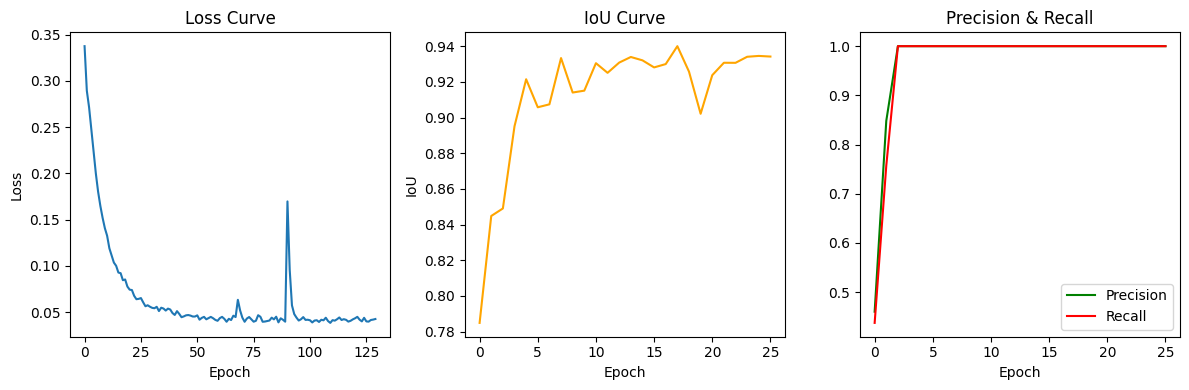

In [ ]:
# ✅ Plotting loss, IoU, precision, and recall curves
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.plot(train_losses, label='Train Loss')
plt.title("Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.subplot(1, 3, 2)
plt.plot(epoch_ious, label='Mean IoU', color='orange')
plt.title("IoU Curve")
plt.xlabel("Epoch")
plt.ylabel("IoU")

plt.subplot(1, 3, 3)
plt.plot(precision_list, label='Precision', color='green')
plt.plot(recall_list, label='Recall', color='red')
plt.title("Precision & Recall")
plt.xlabel("Epoch")
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import time
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import os

model.eval()
y_true_all = []
y_pred_all = []
image_times = []

def draw_matched_boxes(img_tensor, matched_boxes, matched_labels, matched_scores, true_boxes, true_labels, class_names, iou, infer_time, folder_name):
    img_np = img_tensor.permute(1, 2, 0).cpu().numpy()
    img_np = (img_np * 255).astype(np.uint8)

    fig, ax = plt.subplots(1, 1, figsize=(10, 8))
    ax.imshow(img_np)
    ax.set_title(f"[{folder_name}] Avg IoU: {iou:.2f}, Time: {infer_time:.2f}s", fontsize=14)

    # Draw Ground Truth Boxes in RED
    for box, label in zip(true_boxes, true_labels):
        x1, y1, x2, y2 = box
        rect = Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=2, edgecolor='red', facecolor='none')
        ax.add_patch(rect)
        ax.text(x1, y1 - 5, f'GT: {class_names[label - 1]}', color='white', fontsize=10, backgroundcolor='red')

    # Draw ONLY MATCHED Predicted Boxes in GREEN
    for box, label, score in zip(matched_boxes, matched_labels, matched_scores):
        x1, y1, x2, y2 = box
        rect = Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=2, edgecolor='lime', facecolor='none')
        ax.add_patch(rect)
        ax.text(x1, y2 + 10, f'Pred: {class_names[label - 1]} ({score:.2f})', color='black', fontsize=10, backgroundcolor='lime')

    plt.axis('off')
    plt.tight_layout()
    plt.show()

# Evaluate
with torch.no_grad():
    for idx, (images, targets) in enumerate(val_loader):
        image_path = val_dataset.image_paths[idx]
        folder_name = os.path.basename(os.path.dirname(image_path))

        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        start = time.time()
        outputs = model(images)
        end = time.time()
        infer_time = end - start
        image_times.append(infer_time)

        img = images[0].cpu()
        boxes_pred = outputs[0]['boxes'].cpu().numpy()
        labels_pred = outputs[0]['labels'].cpu().numpy()
        scores_pred = outputs[0]['scores'].cpu().numpy()

        boxes_true = targets[0]['boxes'].cpu().numpy()
        labels_true = targets[0]['labels'].cpu().numpy()

        matched_true = []
        matched_pred = []
        matched_boxes = []
        matched_scores = []
        ious = []
        used = set()

        for i, pb in enumerate(boxes_pred):
            best_iou = 0
            best_j = -1
            for j, tb in enumerate(boxes_true):
                if j in used:
                    continue
                ix1 = max(pb[0], tb[0])
                iy1 = max(pb[1], tb[1])
                ix2 = min(pb[2], tb[2])
                iy2 = min(pb[3], tb[3])
                iw = max(ix2 - ix1, 0)
                ih = max(iy2 - iy1, 0)
                inter = iw * ih
                union = (pb[2] - pb[0]) * (pb[3] - pb[1]) + (tb[2] - tb[0]) * (tb[3] - tb[1]) - inter
                iou = inter / union if union > 0 else 0
                if iou > best_iou:
                    best_iou = iou
                    best_j = j

            if best_iou >= 0.5 and best_j not in used and labels_pred[i] == labels_true[best_j]:
                used.add(best_j)
                true_class = labels_true[best_j]
                pred_class = labels_pred[i]
                ious.append(best_iou)

                matched_true.append(true_class)
                matched_pred.append(pred_class)
                matched_boxes.append(boxes_pred[i])
                matched_scores.append(scores_pred[i])

                print(f"[{folder_name}] Image {idx+1}: ✔ GT: {CLASS_NAMES[true_class - 1]}, Pred: {CLASS_NAMES[pred_class - 1]}, IoU: {best_iou:.2f}")

        if matched_true:
            # ✅ Visualize only if there are matched boxes
            draw_matched_boxes(img, matched_boxes, matched_pred, matched_scores, boxes_true, labels_true, CLASS_NAMES, np.mean(ious), infer_time, folder_name)
            y_true_all.extend(matched_true)
            y_pred_all.extend(matched_pred)
        else:
            # ❌ No matched prediction — fallback to highest confidence
            if len(labels_pred) > 0:
                top_pred_label = int(labels_pred[np.argmax(scores_pred)])
                top_true_label = int(labels_true[0])
                print(f"❌ [{folder_name}] Image {idx+1}: GT = {CLASS_NAMES[top_true_label - 1]}, Pred (Top Score) = {CLASS_NAMES[top_pred_label - 1]}, Time = {infer_time:.2f}s")
                y_true_all.append(top_true_label)
                y_pred_all.append(top_pred_label)
            else:
                # ⚠️ No predictions at all
                top_true_label = int(labels_true[0])
                print(f"⚠️ [{folder_name}] Image {idx+1}: GT = {CLASS_NAMES[top_true_label - 1]}, No predictions found, Time = {infer_time:.2f}s")
                y_true_all.append(top_true_label)
                y_pred_all.append(0)  # Use 0 for "no prediction" fallback

# Confusion Matrix (image-level label matching)
if y_true_all and y_pred_all:
    labels_range = list(range(1, len(CLASS_NAMES) + 1))
    cm = confusion_matrix(y_true_all, y_pred_all, labels=labels_range)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=CLASS_NAMES)
    fig, ax = plt.subplots(figsize=(12, 12))
    disp.plot(ax=ax, cmap='Blues', xticks_rotation=90)
    plt.title("📊 Image-Level Confusion Matrix")
    plt.tight_layout()
    plt.show()
else:
    print("⚠️ No matched predictions found to build a confusion matrix.")


Output hidden; open in https://colab.research.google.com to view.

🎯 Accuracy: 1.0000
🔍 Precision: 1.0000
📢 Recall: 1.0000
🏆 F1 Score: 1.0000


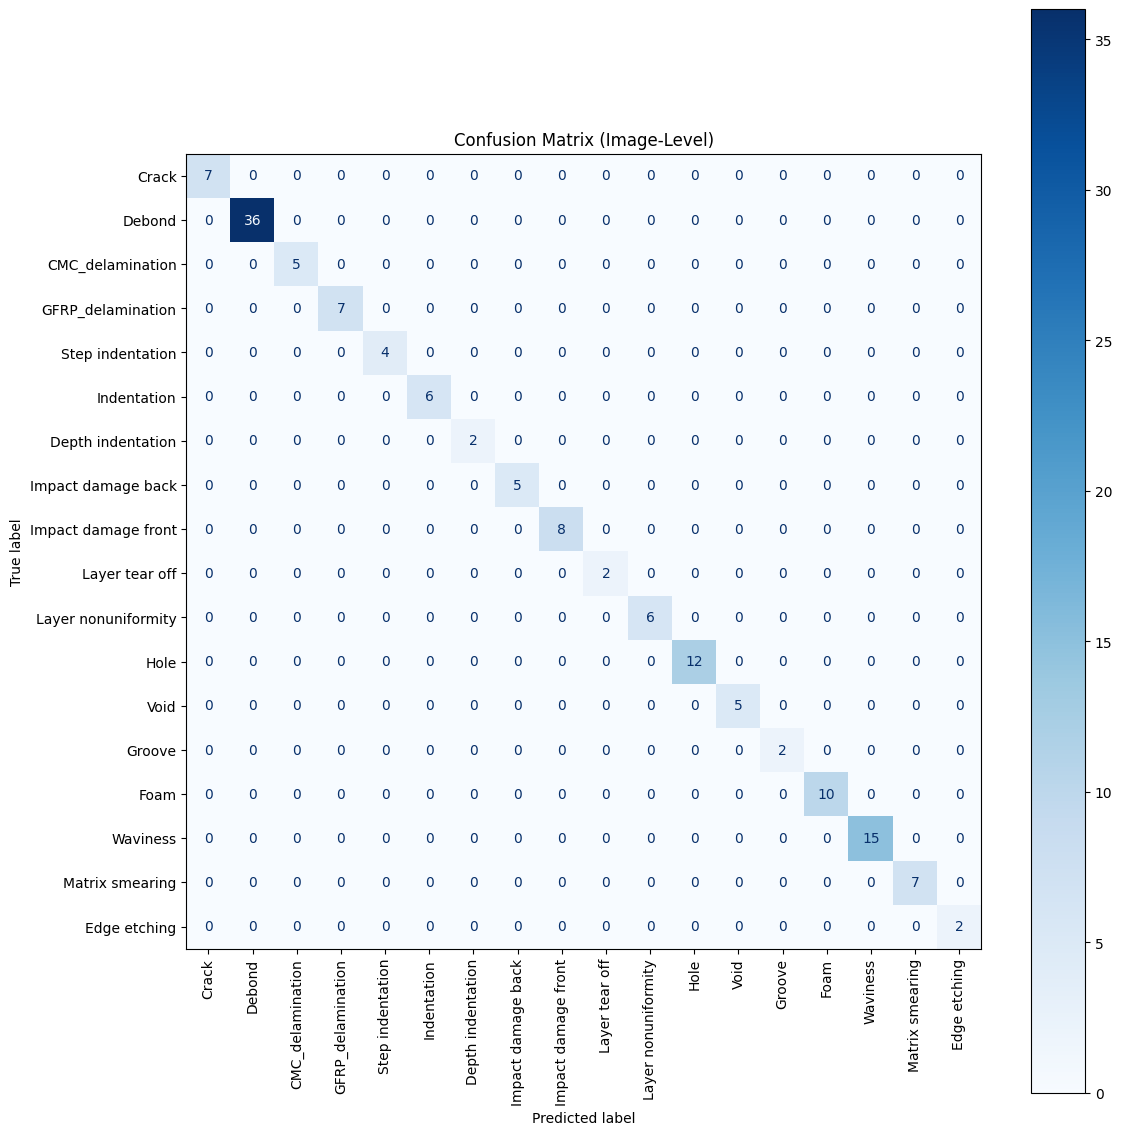

In [ ]:
import torch
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score
import time
import os
import matplotlib.pyplot as plt

# Load the best model
model.load_state_dict(torch.load("best_model.pth"))
model.eval()

y_true_all = []
y_pred_all = []
matched_times = []

with torch.no_grad():
    for idx, (images, targets) in enumerate(val_loader):
        image_path = val_dataset.image_paths[idx]
        folder_name = os.path.basename(os.path.dirname(image_path))

        image = images[0].to(device, non_blocking=True)
        target = {k: v.to(device, non_blocking=True) for k, v in targets[0].items()}

        start = time.time()
        output = model([image])[0]
        end = time.time()

        boxes_pred = output['boxes'].cpu().numpy()
        labels_pred = output['labels'].cpu().numpy()
        scores_pred = output['scores'].cpu().numpy()

        boxes_true = target['boxes'].cpu().numpy()
        labels_true = target['labels'].cpu().numpy()

        matched_true = set()
        matched_pred = set()
        used = set()

        for i, pb in enumerate(boxes_pred):
            best_iou = 0
            best_j = -1
            for j, tb in enumerate(boxes_true):
                if j in used:
                    continue
                ix1, iy1 = max(pb[0], tb[0]), max(pb[1], tb[1])
                ix2, iy2 = min(pb[2], tb[2]), min(pb[3], tb[3])
                iw, ih = max(ix2 - ix1, 0), max(iy2 - iy1, 0)
                inter = iw * ih
                union = (pb[2]-pb[0])*(pb[3]-pb[1]) + (tb[2]-tb[0])*(tb[3]-tb[1]) - inter
                iou = inter / union if union > 0 else 0

                if iou > best_iou:
                    best_iou = iou
                    best_j = j

            if best_iou >= 0.5 and best_j not in used and labels_pred[i] == labels_true[best_j]:
                used.add(best_j)
                matched_true.add(labels_true[best_j])
                matched_pred.add(labels_pred[i])
                matched_times.append(end - start)

        if matched_true:
            y_true_all.append(list(matched_true)[0])
            y_pred_all.append(list(matched_pred)[0])
        else:
            if len(labels_pred) > 0:
                y_true_all.append(list(labels_true)[0])
                y_pred_all.append(int(labels_pred[np.argmax(scores_pred)]))
            else:
                y_true_all.append(list(labels_true)[0])
                y_pred_all.append(-1)

# ✅ Compute valid predictions
valid_preds = [p for p in y_pred_all if p != -1]
valid_trues = [y_true_all[i] for i in range(len(y_true_all)) if y_pred_all[i] != -1]

# ✅ Classification metrics
if valid_preds:
    accuracy = accuracy_score(valid_trues, valid_preds)
    precision = precision_score(valid_trues, valid_preds, average='macro', zero_division=0)
    recall = recall_score(valid_trues, valid_preds, average='macro', zero_division=0)
    f1 = f1_score(valid_trues, valid_preds, average='macro', zero_division=0)

    print(f"🎯 Accuracy: {accuracy:.4f}")
    print(f"🔍 Precision: {precision:.4f}")
    print(f"📢 Recall: {recall:.4f}")
    print(f"🏆 F1 Score: {f1:.4f}")

    cm = confusion_matrix(valid_trues, valid_preds, labels=list(range(1, len(CLASS_NAMES)+1)))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=CLASS_NAMES)
    fig, ax = plt.subplots(figsize=(12, 12))
    disp.plot(ax=ax, cmap='Blues', xticks_rotation=90)
    plt.title("Confusion Matrix (Image-Level)")
    plt.tight_layout()
    plt.show()
else:
    print("⚠️ No valid predictions to create confusion matrix or compute metrics.")


🕒 Average inference time per image in val dataset: 0.001247 seconds
🎯 Accuracy 100.00%


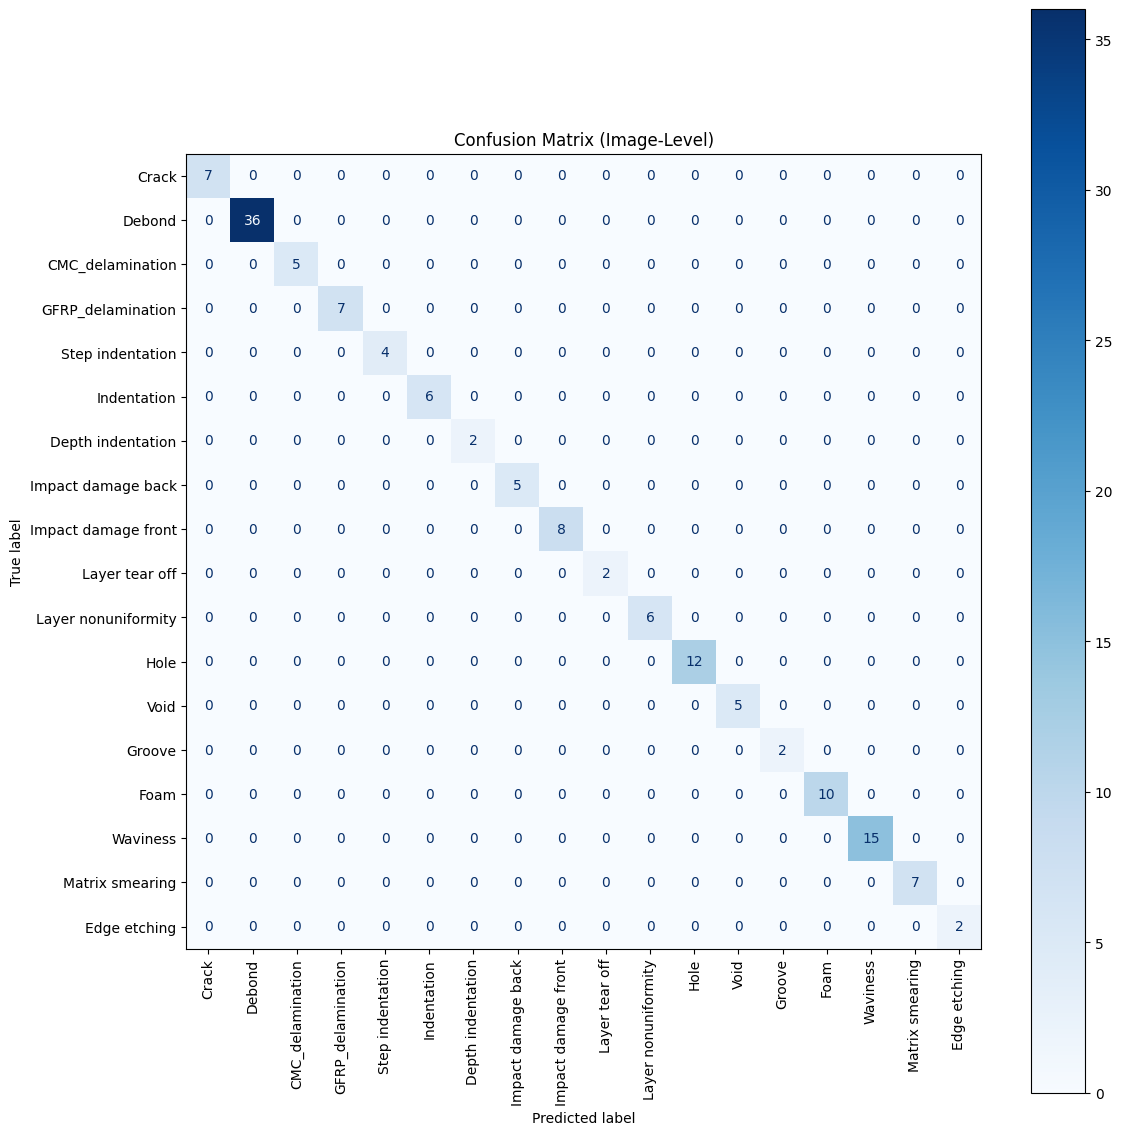

In [ ]:
import torch
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import time
import os
import matplotlib.pyplot as plt
# Load the best model
model.load_state_dict(torch.load("best_model.pth"))
model.eval()
model.eval()
y_true_all = []
y_pred_all = []
image_times = []

total_matching_time = 0.0
num_matches = 0

with torch.no_grad():
    for idx, (images, targets) in enumerate(val_loader):
        image_path = val_dataset.image_paths[idx]
        folder_name = os.path.basename(os.path.dirname(image_path))

        image = images[0].to(device, non_blocking=True)
        target = {k: v.to(device, non_blocking=True) for k, v in targets[0].items()}

        # Start image-level inference timing
        start = time.time()
        output = model([image])[0]
        end = time.time()

        image_times.append(end - start)

        boxes_pred = output['boxes'].cpu().numpy()
        labels_pred = output['labels'].cpu().numpy()
        scores_pred = output['scores'].cpu().numpy()

        boxes_true = target['boxes'].cpu().numpy()
        labels_true = target['labels'].cpu().numpy()

        matched_true = set()
        matched_pred = set()
        used = set()

        for i, pb in enumerate(boxes_pred):
            best_iou = 0
            best_j = -1
            for j, tb in enumerate(boxes_true):
                if j in used:
                    continue
                # Calculate IoU
                ix1, iy1 = max(pb[0], tb[0]), max(pb[1], tb[1])
                ix2, iy2 = min(pb[2], tb[2]), min(pb[3], tb[3])
                iw, ih = max(ix2 - ix1, 0), max(iy2 - iy1, 0)
                inter = iw * ih
                union = (pb[2]-pb[0])*(pb[3]-pb[1]) + (tb[2]-tb[0])*(tb[3]-tb[1]) - inter
                iou = inter / union if union > 0 else 0

                if iou > best_iou:
                    best_iou = iou
                    best_j = j

            if best_iou >= 0.5 and best_j not in used and labels_pred[i] == labels_true[best_j]:
                # Start timing only for successful match
                match_start = time.time()

                used.add(best_j)
                matched_true.add(labels_true[best_j])
                matched_pred.add(labels_pred[i])

                # End timing after successful match
                match_end = time.time()
                total_matching_time += (match_end - match_start)
                num_matches += 1

        if matched_true:
            y_true_all.append(list(matched_true)[0])  # One label per image
            y_pred_all.append(list(matched_pred)[0])
        else:
            if len(labels_pred) > 0:
                y_true_all.append(list(labels_true)[0])  # Pick one GT
                y_pred_all.append(int(labels_pred[np.argmax(scores_pred)]))  # Top predicted class
            else:
                y_true_all.append(list(labels_true)[0])
                y_pred_all.append(-1)  # No prediction
# print  average inference time
avg_match_time = sum(image_times) / len(image_times)
print(f"🕒 Average inference time per image in val dataset: {avg_match_time:.6f} seconds")


# Accuracy (excluding -1 predictions)
valid_preds = [p for p in y_pred_all if p != -1]
valid_trues = [y_true_all[i] for i in range(len(y_true_all)) if y_pred_all[i] != -1]

if valid_preds:
    correct = sum(1 for yt, yp in zip(valid_trues, valid_preds) if yt == yp)
    accuracy = correct / len(valid_preds)
    print(f"🎯 Accuracy {accuracy * 100:.2f}%")

    # Confusion Matrix
    cm = confusion_matrix(valid_trues, valid_preds, labels=list(range(1, len(CLASS_NAMES)+1)))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=CLASS_NAMES)
    fig, ax = plt.subplots(figsize=(12, 12))
    disp.plot(ax=ax, cmap='Blues', xticks_rotation=90)
    plt.title("Confusion Matrix (Image-Level)")
    plt.tight_layout()
    plt.show()
else:
    print("⚠️ No valid predictions to create confusion matrix.")
